In [1]:
# =================================== LIBRERIAS =========================================
import pandas as pd
import patchsim as sim
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import nlopt
import time

In [2]:
# ================================ARCHIVO CONFIG.TXT =====================================

def write_config(beta, symprob, file="files/cfg.txt"):    
    f = open(file, "w")
    f.write("PatchFile=files/pop.txt\n")
    f.write("NetworkFile=files/net.txt\n")
    f.write("NetworkType=Weekly\n")
    f.write("SeedFile=files/seeds.txt\n")
    f.write("ParamFile=files/param.txt\n\n")
    
    f.write("ExposureRate2="+str(beta)+"\n")
    f.write("InfectionRate=0.2173\n")
    f.write("RecoveryRate=0.47\n")
    f.write("SymptomaticProbability="+str(symprob)+"\n\n")
    
    f.write("StartDate=1\n")
    f.write("Duration=500\n\n")

    f.write("LoadState=False\n")
    f.write("SaveState=False\n\n")

    f.write("Model=Mobility\n")
    f.write("OutputFile=resultados.out\n")
    f.write("OutputFormat=Whole\n")
    f.write("LogFile=proceso.log\n")
    f.close()

In [3]:
# ================================ARCHIVO POP.TXT =====================================
# pop.txt: Archivo que contiene las poblaciones

def write_pop(localidades, file="files/pop.txt"):
    df = pd.DataFrame( {"id_localidades":localidades["local_id"].values, 
                             "poblacion":localidades[ "PopCDR" ].values})
    df.to_csv(file, header = False, index = False, sep=' ')
    print("Hay {:,.0f} personas en las 19 localidades.".format(df["poblacion"].sum()))

In [4]:
# ================================ARCHIVO NET.TXT =====================================
# Conexiones: net.txt - Contiene las conectividades de viajes entre cada poblacion 19x19

def write_net(redes, ratios=pd.DataFrame(), file="files/net.txt",
             disminuye_movilidad_60=False):    
    nxn = len(redes)  #19x19
    #-----------------------------------------------------------------------------------
    # Movilidad: Estable
    dias = np.zeros(nxn, dtype=int)
    #-----------------------------------------------------------------------------------
    # Normalizamos matriz de conexiones:
    hbw = redes["hbw"].values
    W = hbw.reshape(-1,19) # Matriz 19x19 Viaje localidad i a j.
    for i in range(19):  
        total_i = np.sum(W[i,:]) # Total en localidad i
        W[i,:] = W[i,:]/total_i
    hbw=W.reshape(-1)
    K = 1
    
    ################### **Disminuyendo movilidad al 60% en cada semana** #################
    
    if disminuye_movilidad_60:
        ratio = np.ones((53, 19)) * 0.60
        K=53  # Identificador
        
    ################ **Disminuyendo movilidad segun ratio en cada semana** #################
    
    if ratios.empty == False:
        # Matriz semana x localidad, cada item contiene radio de disminucion
        ratio = np.ones((53, 19))
        for index, row in ratios.iterrows(): 
            ratio[int(row.week)-1, int(row.loc_id)-1]=row.ratio   
        K=53  # Identificador
        
    if K == 53:  
        for k in range(1,53):  
            W1 = np.zeros((19,19))
            for i in range(19):
                W1[i,:] = W[i,:]*ratio[k,i]
                W1[i,i] = 0
                W1[i,i] = 1 - W1[i,:].sum()
            W = W1.copy()
            hbw = np.append(hbw, W1.reshape(-1))
            dias = np.append(dias, np.zeros(nxn, dtype=int)+k)
    
    #-----------------------------------------------------------------------------------------
    df = pd.DataFrame( {"origen":list(redes["o_loc"].values)*K, 
                        "destino":list(redes["d_loc"].values)*K, 
                        "semana":dias,
                        "hbw":hbw})
    df.to_csv(file, header = False, index = False, sep=' ')

In [5]:
# ================================ARCHIVO PARAM.TXT =====================================

def write_param(ratios, file="files/param.txt"):

    # Matriz dias x localidad, cada item contiene radio de disminucion
    ratio = np.ones((53*7, 19))
    for index, row in ratios.iterrows(): 
        i, j = int(row.week)*7, int(row.loc_id)-1
        ratio[i:i+7,j] = row.ratio 

    alphas = pd.DataFrame(ratio).T 
    alphas.insert(0, "id", np.arange(19)+1, True)
    alphas.to_csv(file, header = False, index = False, sep=' ')
    alphas.head(4)

In [6]:
# =====================================ARCHIVO SEED.TXT ========================================
# Semillas: seeds.txt - Contiene los infectados iniciales durante los primeros 7 dias de
# la pandemia de cada localidad

def write_seed(Casos, file="files/seeds.txt"):

    # Renombrando columnas
    casos = Casos.rename(columns={"LOCALIDAD_ASIS": 'Localidad',
                                  "FECHA_DE_INICIO_DE_SINTOMAS":'fecha'})
                                  #"FECHA_DIAGNOSTICO":'fecha'})
        
    # Convirtiendo en formato fecha de pandas
    casos["fecha"] = pd.to_datetime(casos["fecha"], format="%d/%m/%Y")  # to DateTime
    print("Dia 1 del inicio de sintomas:", casos["fecha"].min())

    # Calculando el tiempo transcurrido en dias
    dia1 = pd.to_datetime("01/01/2020", format="%d/%m/%Y")
    dia1 = casos["fecha"].min()
    tiempo = casos["fecha"] - dia1 # Tiempo transcurrido
    casos['dia'] = tiempo.dt.days 
    casos.dropna(subset=['dia'], inplace=True)
    casos.dia = casos['dia'].apply(np.int)

    # Uniendo base de datos localidades y número de casos
    datos = pd.merge(casos, localidades, on='Localidad')  # Uniendo datos by id: "localidades".

    #  Aplicando función gamma (5)
    datos["dia"] = datos["dia"].apply(lambda x: x-int(np.random.gamma(5)))

    # Encontrando cantidad de casos por dia y localidad
    Ncasos = datos.groupby(['dia', 'local_id']).size().reset_index(name='n_casos_real') 

    #------------------------------------------------------------------------------------------------------------
    #  Generando archivo Semillas: Cantidad de infectados en los primeros 60 dias para cada localidad.
    df = Ncasos[Ncasos["dia"]<=70]
    df.reset_index(drop=True, inplace=True)
    df.to_csv(file, header = False, index = False, sep=' ')
    print("Cantidad de semillas iniciales:", len(df))
    return Ncasos

In [7]:
# =========================================== GRAFICAR ===============================================================
def graficar(Ncasos, infec, fechas=False):
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in np.linspace(0, 1, 19)]
    c=0
    # Graficos
    fig, [ax1,ax2] = plt.subplots(1,2,figsize=(12,4),dpi=120)
    for i in localidades["local_id"].values:
        #--------------------------------------------------------------------------------------------------------------
        # Casos reales
        loc = Ncasos[Ncasos["local_id"]==i] # Localidad i
        casos = loc["n_casos_real"].values
        tiempo = loc["dia"].values
        ax1.plot(tiempo, casos, label="Reales", color=colors[-c])
        #--------------------------------------------------------------------------------------------------------------
        # Casos simulaciones
        infectados = infec.T[i]
        t = np.arange(0, len(infectados))
        ax2.plot(t, symprob*infectados, lw=3, label=str(localidades["Localidad"][i-1]) + " - Loc"+str(i), color=colors[-c])
        ax2.legend(loc="right", bbox_to_anchor=(1.5,0.5), fontsize=8.3)
        #--------------------------------------------------------------------------------------------------------------
        # Propiedades gráficas
        ax1.set_title("Casos de Covid 19 en Bogotá - Reales")
        ax2.set_title("Casos de Covid 19 en Bogotá - Simulados")
        ax1.set_xlabel("dias")
        ax2.set_xlabel("dias")
        ax1.set_ylabel("número de infectados")
        ax2.set_ylabel("número de infectados")
        ax1.grid()
        ax2.grid()
        ax1.set_xticks(np.linspace(0,500,11))
        ax2.set_xticks(np.linspace(0,500,11))
        ax1.set_xlim(0,500)
        c+=1
    if fechas:
        dia1 = pd.to_datetime("01/01/2020", format="%d/%m/%Y")
        fechas = Ncasos["dia"].apply(lambda x: (dia1+dt.timedelta(days=x)).strftime("%d/%m/%Y"))
        dias = lambda ax: [(dia1+dt.timedelta(days=i)).strftime("%d/%b/%Y") for i in ax.get_xticks()]
        ax2.set_xticklabels(dias(ax2), rotation=60)
        ax1.set_xticklabels(dias(ax1), rotation=60)
    return ax1, ax2

# Definiendo variables de entrada 

In [8]:
# Leyendo archivos
localidades = pd.read_csv("files/info_local_2020.csv")
conexiones = redes = pd.read_csv("files/cdr_od_loc.csv")
ratios = pd.read_csv("files/agregados_localidad.csv")
Semillas = pd.read_csv("files/osb_enftransm-covid-19_17042021.csv", nrows=732872, encoding='latin-1', delimiter=";")

# Escribiendo archivos
write_pop(localidades)
write_net(conexiones, ratios)
write_param(ratios)
casos_reales = write_seed(Semillas)

Hay 5,549,758 personas en las 19 localidades.
Dia 1 del inicio de sintomas: 2020-02-26 00:00:00
Cantidad de semillas iniciales: 1005


# Ejecutando función PatchSim

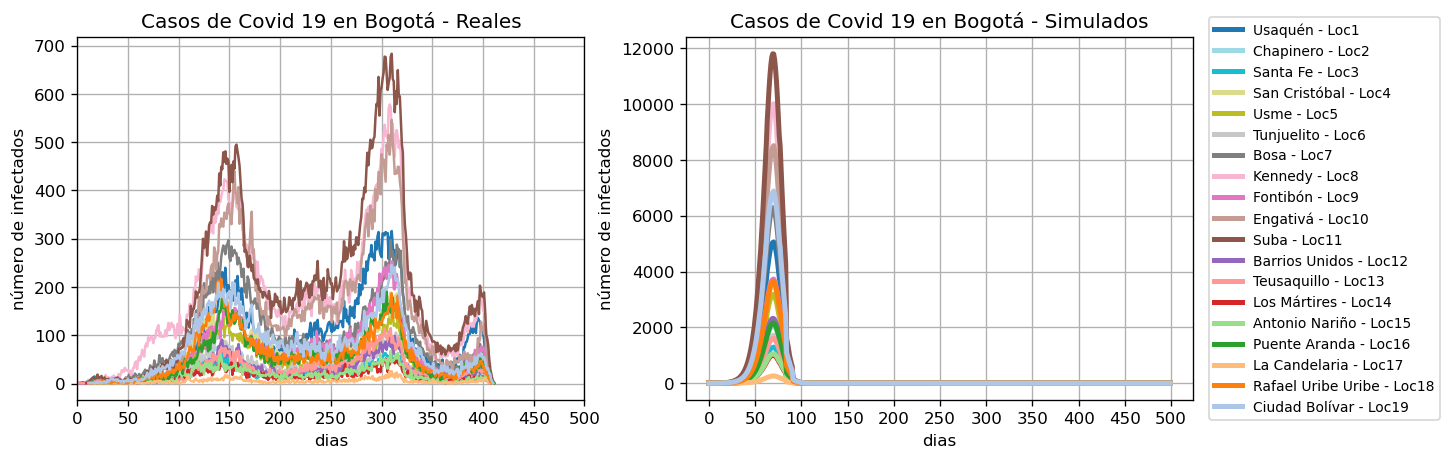

In [9]:
#---------------------------------------------------------------------------------------------------------------------
beta, symprob = [1.7, 0.4]
write_config(beta, symprob)
configs = sim.read_config('files/cfg.txt')
sim.run_disease_simulation(configs, write_epi=True)

#---------------------------------------------------------------------------------------------------------------------
# Infectados simulados:
infec = np.loadtxt("resultados.out")
infec = pd.DataFrame(infec, index=infec.T[0]).drop(0, axis=1)
infec = infec.sort_index()

#----------------------------------------------------------------------------------------------------------------------
# Grafica:
[ax1, ax2] = graficar(casos_reales, infec)
#ax2.set_ylim(0,4500)

In [10]:
def simular(x, grad):
    # Escribiendo archivo cfg.txt
    beta, symprob = x[0], x[1]
    write_config(beta, symprob)
    
    # Corriendo simulacion
    configs = sim.read_config('files/cfg.txt')
    sim.run_disease_simulation(configs, write_epi=True)

    # DataFrame de Infectados reales y simulados
    infec = np.loadtxt("resultados.out")
    infec = pd.DataFrame(infec, index=infec.T[0]).drop(0, axis=1)
    x, y = np.meshgrid(infec.columns, infec.index)
    infecs = pd.DataFrame(np.transpose([x.ravel(),y.ravel(),infec.values.ravel()]), 
                            columns=["dia", "local_id", "n_casos_sim"])
    Inf = pd.merge(infecs, casos_reales, on=['dia','local_id'],  how='right')
    
    # Error   
    Error = (Inf["n_casos_real"][60:260] - symprob*Inf["n_casos_sim"][60:260])**2
    Error = Error.sum().sum()/(260-60)/19
    return Error

# Optimizacion:
def Optimizar(b0, sp0):
    n = 2 # Numero de variables a optimizar : Beta y SymProb
    Nitr = 1000 # Numero maximo de iteraciones 

    inf = [0.5, 0.05] # Limites inferiores
    sup = [5, 1]  # Limites superiores

    opt = nlopt.opt(nlopt.LN_NELDERMEAD, n)
    opt.set_lower_bounds(inf)
    opt.set_upper_bounds(sup)
    opt.set_maxeval(Nitr)
    opt.set_min_objective(simular)
    opt.set_xtol_rel(1e-5)
    x0 = np.array([b0, sp0])
    x = opt.optimize(x0)
    return x

In [11]:
emin = 1e10
t1 = time.time()
for i in np.linspace(0.5,5,6):
    for j in np.linspace(0.05,1,6):
        x = Optimizar(i,j)
        Error = simular(x,0)
        print("beta: %.5f, symprob: %.5f, Error: %.5f"%(x[0],x[1],Error))
        if Error<emin:
            emin=Error
            k=(i,j,Error)
t2 = time.time()
print("-------------------------------------------------")
print("Tiempo de ejecucion: ", t2-t1, "segundos")
print("Beta*=%.5f, Symprob*=%.5f, Error=%.5f"%(k))

beta: 5.00000, symprob: 0.05000, Error: 648.16256
beta: 0.50000, symprob: 0.55729, Error: 647.82875
beta: 0.50000, symprob: 0.55722, Error: 647.82874
beta: 0.50000, symprob: 0.55722, Error: 647.82874
beta: 0.50000, symprob: 0.55722, Error: 647.82874
beta: 0.50000, symprob: 0.55840, Error: 647.83127
beta: 5.00000, symprob: 0.05000, Error: 648.16256
beta: 1.96536, symprob: 0.15015, Error: 647.65800
beta: 2.33022, symprob: 0.69577, Error: 648.26244
beta: 2.20487, symprob: 0.80952, Error: 648.25873
beta: 2.13320, symprob: 0.91113, Error: 648.26022
beta: 2.15297, symprob: 0.94571, Error: 648.27052
beta: 5.00000, symprob: 0.05000, Error: 648.16256
beta: 3.26193, symprob: 0.39151, Error: 648.26161
beta: 3.04542, symprob: 0.43290, Error: 648.26176
beta: 2.61176, symprob: 0.55344, Error: 648.26012
beta: 2.20474, symprob: 0.80952, Error: 648.25873
beta: 2.20456, symprob: 0.80952, Error: 648.25873
beta: 5.00000, symprob: 0.05000, Error: 648.16256
beta: 4.03664, symprob: 0.29298, Error: 648.26053


In [12]:
beta: 0.50000, symprob: 0.05000, Error: 642.07895
beta: 0.50001, symprob: 0.24000, Error: 642.07895
beta: 1.61304, symprob: 0.50998, Error: 585.77902
beta: 0.50000, symprob: 0.62000, Error: 642.07895
beta: 1.24973, symprob: 0.81112, Error: 584.87872
beta: 1.06250, symprob: 1.00000, Error: 640.54684
beta: 1.40001, symprob: 0.05000, Error: 642.07895
beta: 1.40002, symprob: 0.24000, Error: 642.07895
beta: 1.89210, symprob: 0.41047, Error: 586.15610
beta: 1.36680, symprob: 0.66552, Error: 585.25287
beta: 1.19415, symprob: 0.99702, Error: 584.31405
beta: 0.72501, symprob: 0.52500, Error: 642.07895
beta: 2.30002, symprob: 0.05000, Error: 642.07895
beta: 2.23684, symprob: 0.33328, Error: 586.43491
beta: 3.34547, symprob: 0.21039, Error: 586.98590
beta: 3.07153, symprob: 0.77188, Error: 572.82671
beta: 3.07398, symprob: 0.77053, Error: 572.82706
beta: 3.12086, symprob: 0.74599, Error: 572.91221
beta: 3.66926, symprob: 0.19024, Error: 587.07693
beta: 3.20002, symprob: 0.16875, Error: 642.07895
beta: 4.99992, symprob: 0.66750, Error: 642.07895
beta: 3.54323, symprob: 0.59389, Error: 573.25279
beta: 2.99981, symprob: 0.81635, Error: 572.69203
beta: 3.05640, symprob: 0.78053, Error: 572.83243
beta: 4.10004, symprob: 0.05001, Error: 642.07895
beta: 3.85988, symprob: 0.18009, Error: 587.11867
beta: 4.43464, symprob: 0.43034, Error: 573.80101
beta: 4.16733, symprob: 0.46785, Error: 573.64986
beta: 4.10004, symprob: 0.81001, Error: 642.07895
beta: 4.10004, symprob: 0.99999, Error: 642.07895
beta: 4.99993, symprob: 0.05001, Error: 642.07895
beta: 4.08394, symprob: 0.16952, Error: 587.16588
beta: 4.43692, symprob: 0.42992, Error: 573.79113
beta: 4.65520, symprob: 0.40377, Error: 573.83050
beta: 4.99993, symprob: 0.81001, Error: 642.07895
beta: 4.99993, symprob: 0.99999, Error: 642.07895
-------------------------------------------------
Tiempo de ejecucion:  782.1083085536957 segundos
Beta*=3.20000, Symprob*=0.81000, Error=572.69203

SyntaxError: invalid syntax (<ipython-input-12-07acfdead657>, line 1)